# PyEarthScience:  Python examples for Earth Scientists

## contour plots

### Using PyNGL

#### Contour plot with
    - ICON model data
    - unstructured grid
    - colored triangles
    - CellFill

In [1]:
import numpy as np
import math, time
import Ngl,Nio

Retrieve time for wallclock time computation.

In [2]:
t1 = time.time()                                   #-- retrieve start time
print ""

Open file and read variables.

In [3]:
#--  define variables 
diri, fname  = '$HOME/data/ICON/', 'ta_ps_850.nc'   #-- data path and file name
gname        = 'grids/r2b4_amip.nc'                 #-- grid info file
VarName      = 'ta'                                 #-- variable name       
 
#--  open file and read variables 
f = Nio.open_file(diri + fname,'r')                 #-- add data file
g = Nio.open_file(diri + gname,'r')                 #-- add grid file (not contained in data file!!!)
 
#-- read a timestep of 'ta'  
variable =  f.variables['ta']                       #-- first time step, lev, ncells
data     =  variable[0,0,:]                         #-- ta [time,lev,ncells]; miss _FillValue
var      =  data - 273.15                           #-- convert to degrees Celsius; miss _FillValue

#-- define _FillValue and missing_value if not existing
missing = -1e20

if not hasattr(var,'_FillValue'):
   var._FillValue  =  missing                       #-- set _FillValue
if not hasattr(var,'missing_value'): 
   var.missing_value =  missing                     #-- set missing_value

varM = np.ma.array(var, mask=np.equal(var,missing)) #-- mask array with missing values 
nummissing = np.count_nonzero(varM.mask)            #-- number of missing values

Define title string, minimum and maximum contour values, interval and levels.

In [4]:
#-- set data intervals, levels, labels, color indices
varMin, varMax, varInt = -32, 28, 4                 #-- set data minimum, maximum, interval
 
levels   =  range(varMin,varMax,varInt)             #-- set levels array
nlevs    =  len(levels)                             #-- number of levels
labels   = ['{:.2f}'.format(x) for x in levels]     #-- convert list of floats to list of strings
colors   =  range(2,nlevs+6)                        #-- create color indices

#-- print info to stdout
print ''
print 'min/max:          %.2f' %np.min(varM) + ' /' + ' %.2f' %np.max(varM)
print ''
print 'varMin:           %3d' %varMin
print 'varMax:           %3d' %varMax
print 'varInt:           %3d' %varInt
print ''
print 'missing_value:    ', missing
print 'missing values:   ', nummissing


min/max:          -34.87 / 21.07

varMin:           -32
varMax:            28
varInt:             4

missing_value:     -1e+20
missing values:    956


Define the x-, y-values and the polygon points.

In [5]:
rad2deg = 45./np.arctan(1.)                         #-- radians to degrees

x, y       =  g.variables['clon'][:], g.variables['clat'][:]
vlon, vlat =  g.variables['clon_vertices'][:], g.variables['clat_vertices'][:]

x, y       =  x*rad2deg,  y*rad2deg                 #-- cell center, lon, lat
vlat, vlon =  vlat*rad2deg, vlon * rad2deg          #-- cell latitude/longitude vertices
ncells, nv =  vlon.shape                            #-- ncells: number of cells; nv: number of edges

#-- print information to stdout
print ''
print 'cell points:      ', nv
print 'cells:            ', str(ncells)
print ''

#-- rearrange the longitude values to -180.-180.
def rearrange(vlon):
    less_than    = vlon < -180.
    greater_than = vlon >  180.
    vlon[less_than]    = vlon[less_than] + 360.
    vlon[greater_than] = vlon[greater_than] - 360.
    return vlon

vlon = rearrange(vlon)                              #-- set longitude values to -180.-180. degrees

print 'min/max vlon:     ', np.min(vlon), np.max(vlon)
print 'min/max vlat:     ', np.min(vlat), np.max(vlat)
print ''


cell points:       3
cells:             20480

min/max vlon:      -180.0 180.0
min/max vlat:      -90.0 90.0



Open workstation for first plot, here x11 window.

In [6]:
wkres       =  Ngl.Resources()
wkres.wkColorMap =  'WhiteBlueGreenYellowRed'       #-- choose colormap
wkres.wkWidth, wkres.wkHeight  =  2500, 2500
wks1_type   = 'png'
wks1 =  Ngl.open_wks(wks1_type,'plot_unstructured_ICON_triangles',wkres)

Create color map for the triangles.

In [7]:
#-- define colormap
cmap     =  Ngl.retrieve_colormap(wks1)             #-- RGB ! [256,3]
ncmap    =  cmap.shape[0]                           #-- number of colors
colormap =  cmap[:ncmap:12,:]                       #-- select every 13th color 
ncol     =  colormap.shape[0]
colormap[20] = ([1.,1.,1.])                         #-- white for missing values

print 'colors index:     ', colors 
print ''
print 'levels:           ',levels
print 'labels:           ',labels
print ''
print 'nlevs:            %3d' %nlevs
print 'ncols:            %3d' %ncol
print ''

#-- overwrite resources of wks1
setlist                    =  Ngl.Resources()
setlist.wkColorMap         =  colormap              #-- set color map to new colormap array
setlist.wkBackgroundColor  = 'white'                #-- has to be set when wkColorMap is set to colormap array
setlist.wkForegroundColor  = 'black'                #-- has to be set when wkColorMap is set to colormap array
Ngl.set_values(wks1,setlist)

colors index:      [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

levels:            [-32, -28, -24, -20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20, 24]
labels:            ['-32.00', '-28.00', '-24.00', '-20.00', '-16.00', '-12.00', '-8.00', '-4.00', '0.00', '4.00', '8.00', '12.00', '16.00', '20.00', '24.00']

nlevs:             15
ncols:             22



-1

Set resources and create the base map.

In [8]:
#-- set map resources
mpres                             =  Ngl.Resources()
mpres.nglDraw                     =  False          #-- turn off plot draw and frame advance. We will
mpres.nglFrame                    =  False          #-- do it later after adding subtitles.
mpres.mpGridAndLimbOn             =  False
mpres.mpGeophysicalLineThicknessF =  2.
mpres.pmTitleDisplayMode          = 'Always'
mpres.tiMainString                = 'PyNGL: unstructured grid ICON'

#-- create only a map
map = Ngl.map(wks1,mpres)
Ngl.draw(map)

Create the array containing the color for each triangle.

In [9]:
#-- assign and initialize array which will hold the color indices of the cells
gscolors = -1*(np.ones((ncells,),dtype=np.int))     #-- assign array containing zeros; init to transparent: -1

#-- set color index of all cells in between levels
for m in xrange(0,nlevs):
    vind = []                                       #-- empty list for color indices
    for i in xrange(0,ncells-1):
        if (varM[i] >= levels[m] and varM[i] < levels[m+1]):
           gscolors[i] = colors[m+1]
           vind.append(i)
    print 'finished level %3d' % m , ' -- %5d ' % len(vind) , ' polygons considered - gscolors %3d' % colors[m]
    del vind

gscolors[varM < varMin]         =  colors[0]        #-- set color index for cells less than level[0]
gscolors[varM >= varMax]        =  colors[(nlevs-1)+2] #-- set color index for cells greater than levels[nlevs-1]
gscolors[np.nonzero(varM.mask)] =  20               #-- set color index for missing values

finished level   0  --   402   polygons considered - gscolors   2
finished level   1  --   583   polygons considered - gscolors   3
finished level   2  --   447   polygons considered - gscolors   4
finished level   3  --   515   polygons considered - gscolors   5
finished level   4  --   713   polygons considered - gscolors   6
finished level   5  --   952   polygons considered - gscolors   7
finished level   6  --  1075   polygons considered - gscolors   8
finished level   7  --  1303   polygons considered - gscolors   9
finished level   8  --  1603   polygons considered - gscolors  10
finished level   9  --  2184   polygons considered - gscolors  11
finished level  10  --  2778   polygons considered - gscolors  12
finished level  11  --  5378   polygons considered - gscolors  13
finished level  12  --  1496   polygons considered - gscolors  14
finished level  13  --    37   polygons considered - gscolors  15
finished level  14  --     0   polygons considered - gscolors  16


Set polygon resources and add the polygons to the base map.

In [10]:
pgres                   =  Ngl.Resources()
pgres.gsEdgesOn         =  True                     #-- draw the edges
pgres.gsFillIndex       =  0                        #-- solid fill
pgres.gsLineColor       = 'black'                   #-- edge line color
pgres.gsLineThicknessF  =  0.7                      #-- line thickness
pgres.gsColors          =  gscolors                 #-- use color array
pgres.gsSegments        =  range(0,len(vlon[:,0])*3,3) #-- define segments array

x1d, y1d = np.ravel(vlon), np.ravel(vlat)           #-- convert to 1D-arrays

#-- add polygons to map
polyg  = Ngl.add_polygon(wks1,map,x1d,y1d,pgres)

Create a labelbar.

In [11]:
lbres                   =  Ngl.Resources()
lbres.vpWidthF          =  0.85
lbres.vpHeightF         =  0.15
lbres.lbOrientation     = 'Horizontal'
lbres.lbFillPattern     = 'SolidFill'
lbres.lbMonoFillPattern =  21                       #-- must be 21 for color solid fill
lbres.lbMonoFillColor   =  False                    #-- use multiple colors
lbres.lbFillColors      =  colors                   #-- indices from loaded colormap
lbres.lbBoxCount        =  len(colormap[colors,:])
lbres.lbLabelFontHeightF=  0.014
lbres.lbLabelAlignment  = 'InteriorEdges'
lbres.lbLabelStrings    =  labels

lb = Ngl.labelbar_ndc(wks1,nlevs+1,labels,0.1,0.24,lbres)

Maximize the plot output.

In [12]:
Ngl.maximize_plot(wks1, map)
Ngl.draw(map)
Ngl.frame(wks1)

Compute the wallclock time.

In [13]:

#-- get wallclock time
t2 = time.time()
print ''
print 'Wallclock time:  %0.3f seconds' % (t2-t1)
print ''

Ngl.end()


Wallclock time:  6.447 seconds



Show the plots in this notebook.

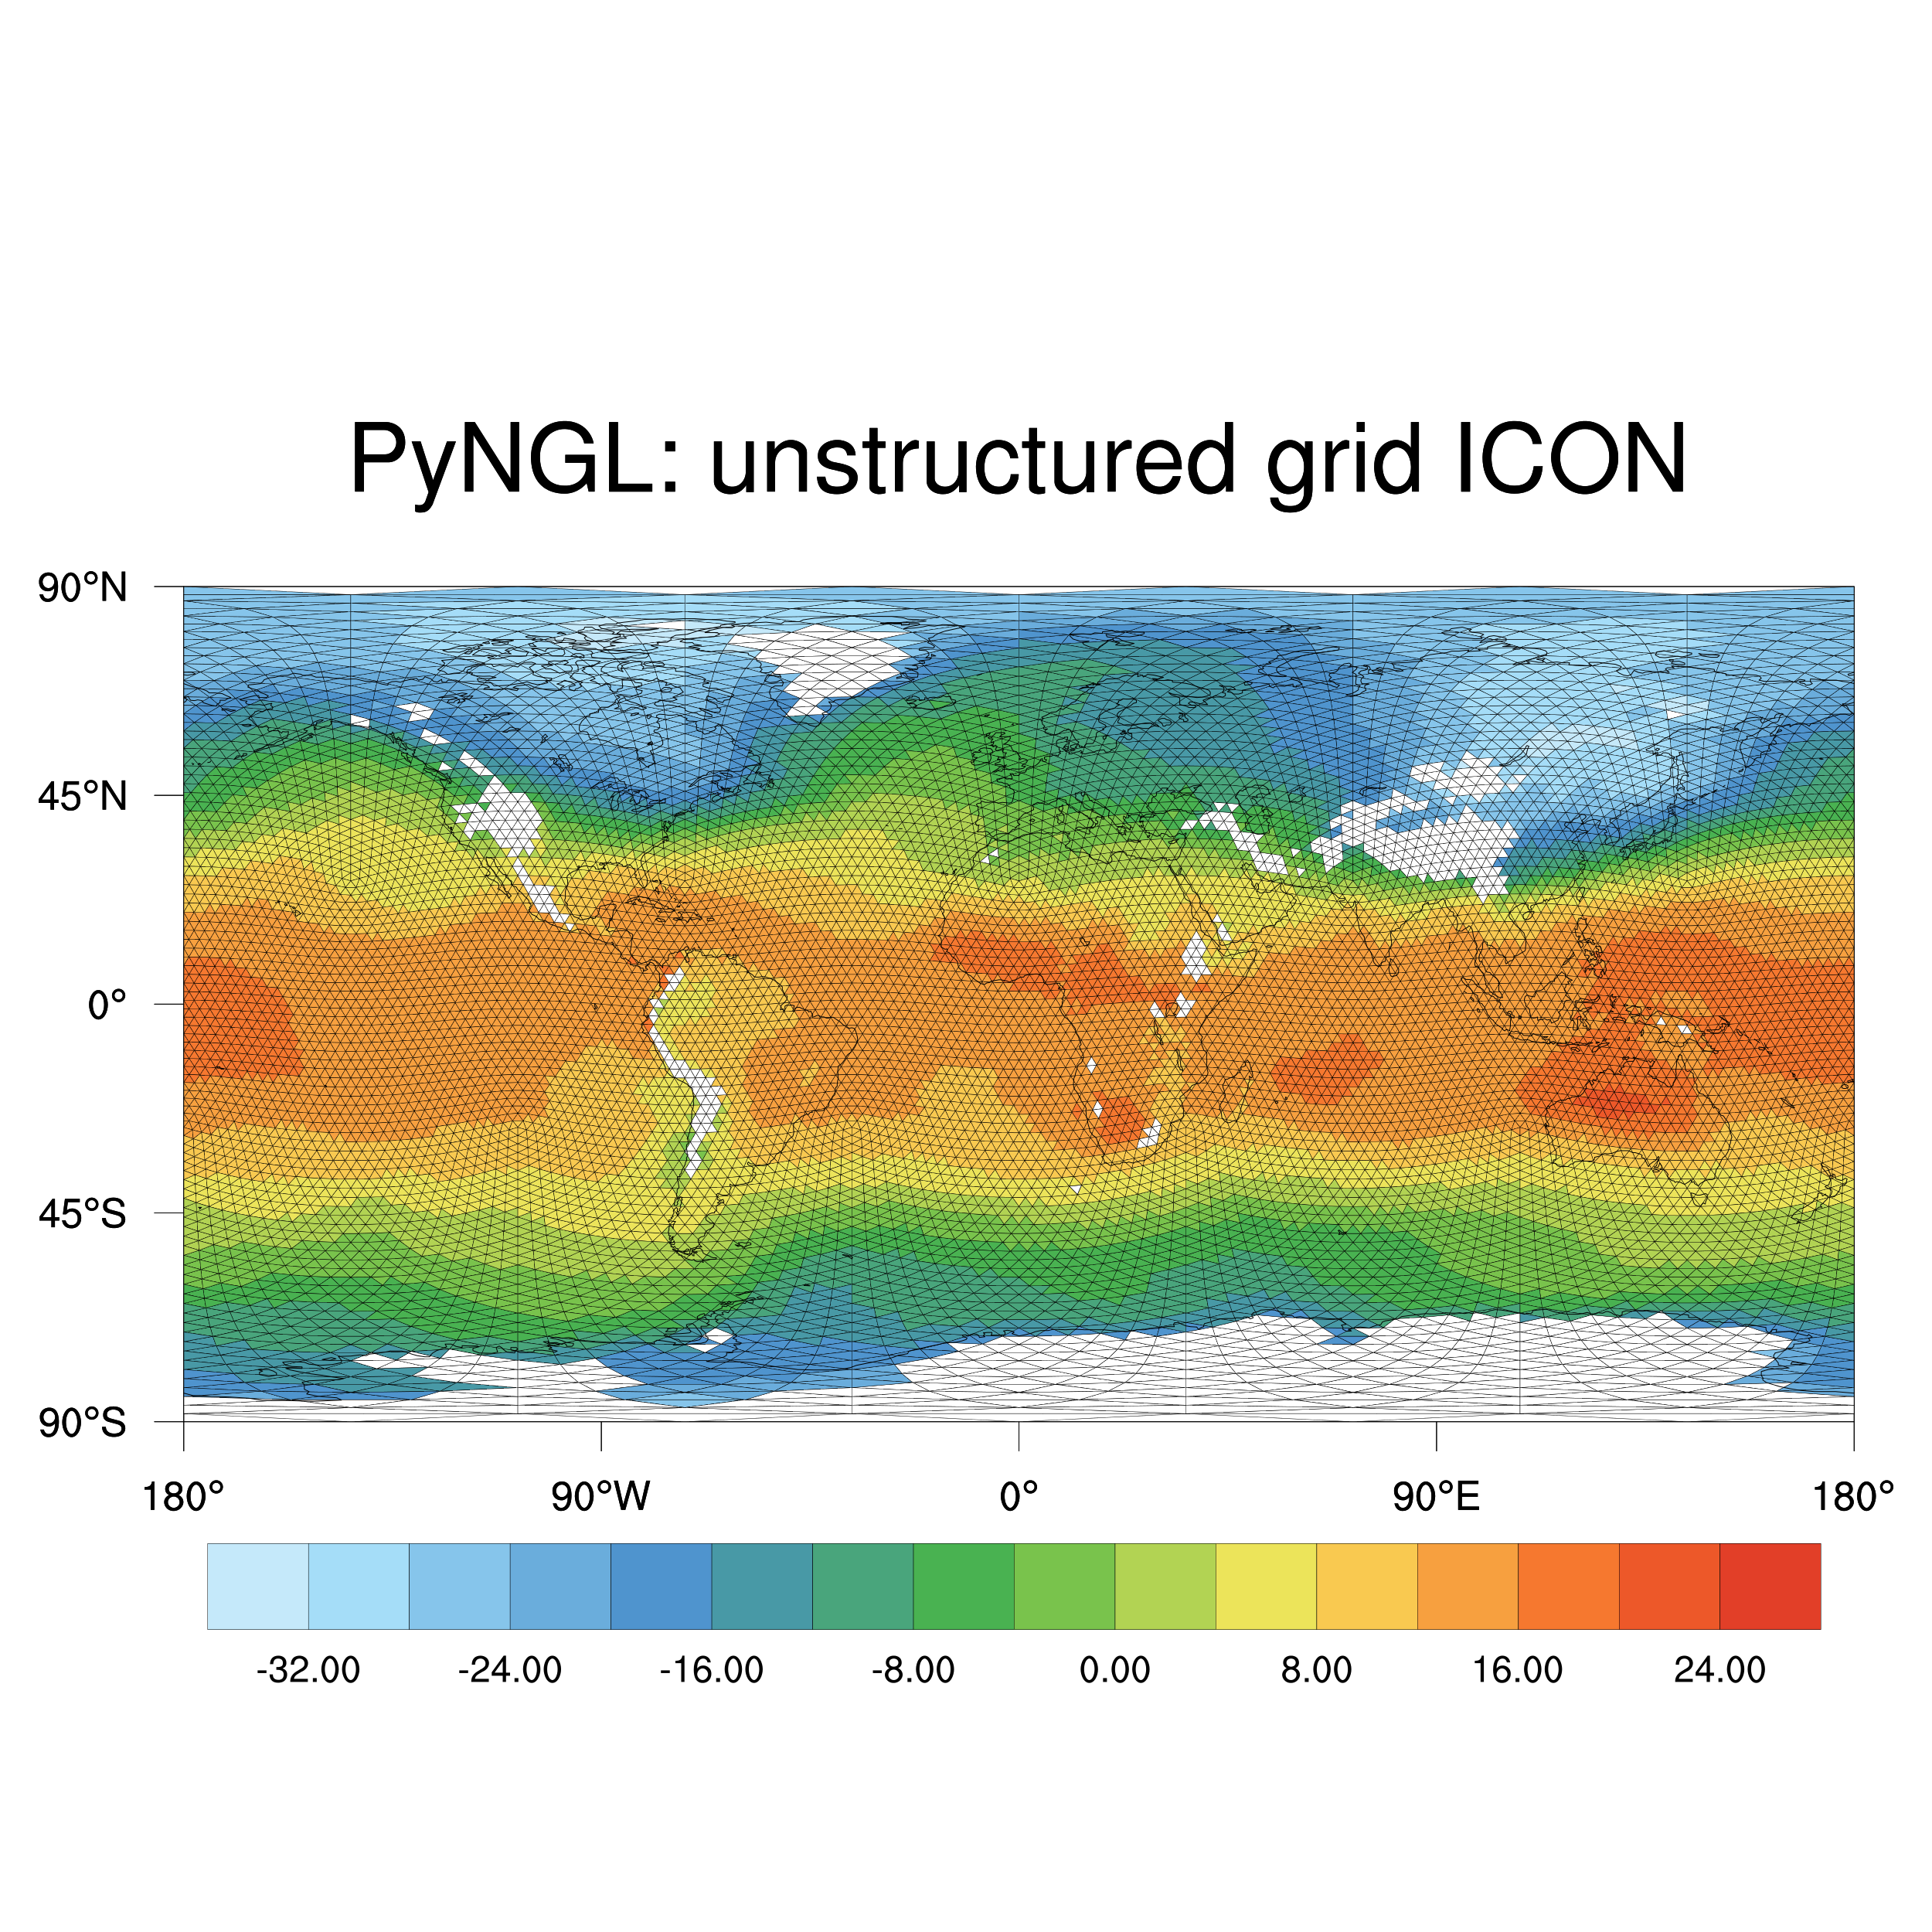

In [14]:
from IPython.display import Image
Image(filename='plot_unstructured_ICON_triangles.png')